In [1]:
! pip install -U rouge

In [0]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow import keras
import rouge
from rouge import Rouge

In [3]:
print(tf.__version__, rouge.__version__)

2.2.0-rc2 1.0.0


In [4]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
reviews_df = pd.read_csv('/content/drive/My Drive/Amazon_Reviews.csv')

In [6]:
reviews_df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [0]:
neg_df = reviews_df[reviews_df['Score'] <= 4].sample(40000, random_state=46)

neg_df = neg_df.dropna(subset=['Summary'])

## (Optional) Load Pre-Processed Texts/Summaries

In [0]:
import pickle

drive_path = '/content/drive/'

file_path = 'My Drive/'

sum_df = pickle.load(open(drive_path + file_path + 'bootstrap_cfpb_df_main', 'rb'))

## Load CSV of CFPB Complaints and Summaries

In [136]:
cfpb_df = pd.read_csv('/content/drive/My Drive/cfpb_summaries_master.csv')

tmp_sum_df = cfpb_df.dropna(subset=['Summary'])

tmp_sum_df['Text'] = tmp_sum_df['Consumer complaint narrative']

tmp_sum_df = tmp_sum_df[['Text', 'Summary']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Build Test DF

### Just tmp_sum_df test samples

In [0]:
test_df = tmp_sum_df.sample(250, random_state=5).dropna(subset=['Summary'])

test_df_pure = test_df[['Text', 'Summary']]

to_remove = test_df_pure.index.tolist()

tmp_sum_df = tmp_sum_df.drop(to_remove)

tmp_sum_df = tmp_sum_df.reset_index(drop=True)

for i in range(1):

  sum_df = sum_df.append(tmp_sum_df)

### Rest of DFs

In [138]:
# Build test_df
test_df = sum_df.sample(750, random_state=8).dropna(subset=['Summary'])

test_df = test_df[['Text', 'Summary']]

# Remove rows that were sampled for test_df
to_remove = test_df.index.tolist()

sum_df = sum_df.drop(to_remove)

test_df = test_df.append(test_df_pure)

print(len(test_df.reset_index(drop=True)))

1000


In [0]:
# sum_df = sum_df.append(neg_df)

comb_df = sum_df

In [121]:
print(f'\nNumber of cfpb summaries:', sum_df.shape[0], '\nNumber of amazon summaries:', neg_df.shape[0], '\n')

print(f'Percent cfpb', 100*round(sum_df.shape[0]/(sum_df.shape[0] + neg_df.shape[0]), 3), '%\n')


Number of cfpb summaries: 86141 
Number of amazon summaries: 39997 

Percent cfpb 68.30000000000001 %



## Clean Texts

In [140]:
clean = [re.sub('[^A-Za-z.,\s\']', '', str(text)) for text in comb_df['Text']]

split_word_nars = [nar.split() for nar in clean]

"""Contractions Import"""

import sys
sys.path.append('/content/drive/My Drive')
from english_contractions import replace_contraction

""" Stop Words Import """

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

""" Loops """

new_words = []

for nar in split_word_nars:

  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append('.')
    
    elif re.search('\w+[,]', word):
      
      splitted = word.split(',')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append(',')
    
    elif re.match('[.]', word):
      
      placeholder = 1
    
    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)
  
  nar_words = [word for word in nar_words if not word in stops]

  new_words.append(' '.join(nar_words))

texts = new_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Clean Summaries

In [0]:
clean = [re.sub('[^A-Za-z.,\s\']', '', str(text)) for text in comb_df['Summary']]

split_word_nars = [nar.split() for nar in clean]

"""Contractions Import"""

import sys
sys.path.append('/content/drive/My Drive')
from english_contractions import replace_contraction

""" Loops """

new_words = []

for nar in split_word_nars:

  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append('.')
    
    elif re.search('\w+[,]', word):
      
      splitted = word.split(',')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append(',')
    
    elif re.match('[.]', word):
      
      placeholder = 1
    
    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)

  new_words.append(' '.join(nar_words))

summaries = new_words

## Clean Test Text and Summaries

In [0]:
# Texts

clean = [re.sub('[^A-Za-z.,\s\']', '', str(text)) for text in test_df['Text']]

split_word_nars = [nar.split() for nar in clean]

stops = set(stopwords.words('english'))

""" Loops """

new_words = []

for nar in split_word_nars:

  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append('.')
    
    elif re.search('\w+[,]', word):
      
      splitted = word.split(',')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append(',')
    
    elif re.match('[.]', word):
      
      placeholder = 1
    
    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)
  
  nar_words = [word for word in nar_words if not word in stops]

  new_words.append(' '.join(nar_words))

test_texts = new_words

# Summaries

clean = [re.sub('[^A-Za-z.,\s\']', '', text) for text in test_df['Summary']]

split_word_nars = [nar.split() for nar in clean]

new_words = []

for nar in split_word_nars:

  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append('.')
    
    elif re.search('\w+[,]', word):
      
      splitted = word.split(',')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append(',')
    
    elif re.match('[.]', word):
      
      placeholder = 1
    
    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)

  new_words.append(' '.join(nar_words))

test_summaries = new_words

## Build Clean Df

In [143]:
comb_df['Cleaned_text'], comb_df['Cleaned_summary'] = texts, summaries

clean_df = comb_df[['Cleaned_text', 'Cleaned_summary']]

target_texts = []

for target_text in clean_df['Cleaned_summary']:

  target_text = '_START_ ' + str(target_text) + ' _END_'

  target_texts.append(target_text)

clean_df['Summary'] = target_texts

# test_df

test_df['Cleaned_text'], test_df['Cleaned_summary'] = test_texts, test_summaries

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## AttentionLayer Class

In [0]:
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## (Optional) Load Model and Tokenizer

In [0]:
import pickle

# load model

drive_path = '/content/drive/'

file_path = 'My Drive/saved_keras_rnns/'

name = 'enc_dec_sub_prime.h5'

model = keras.models.load_model(drive_path + file_path + name, custom_objects={'AttentionLayer': AttentionLayer})

# build pre-trained model

config = model.get_config()

weights = model.get_weights()

model = tf.keras.Model.from_config(config, custom_objects={'AttentionLayer': AttentionLayer})

model.set_weights(weights)

# load tokenizer

name = 'tok_enc_dec_sub_prime.pkl'

(x_tokenizer, y_tokenizer) = pickle.load(open(drive_path + file_path + name, 'rb'))

# load rouge scores

rouge_scores_tuple = pickle.load(open('/content/drive/My Drive/rouge_score_prime.pkl', 'rb'))

## Train/Val Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(clean_df['Cleaned_text'], clean_df['Summary'], test_size=0.1, random_state=15, shuffle=True)

## Tokenize Text

### Reviews

In [150]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len_text = 200

max_len_summary = 5

# x_tokenizer = tf.keras.preprocessing.text.Tokenizer()

# x_tokenizer.fit_on_texts(list(X_train))

# convert text sequences into integer sequences
X_train = x_tokenizer.texts_to_sequences(X_train)
X_val = x_tokenizer.texts_to_sequences(X_val)

# padding zero up to maximum length
X_train = pad_sequences(X_train, maxlen=max_len_text, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

x_voc_size

48655

### (Optional) Summaries Regular

In [147]:
# y_tokenizer = tf.keras.preprocessing.text.Tokenizer()

# y_tokenizer.fit_on_texts(list(y_train))

# convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train)
y_val = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

y_voc_size

NameError: ignored

### Tokenize Summaries with x_tokenizer

In [151]:
# convert summary sequences into integer sequences
y_train = x_tokenizer.texts_to_sequences(y_train)
y_val = x_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(x_tokenizer.word_index) + 1

y_voc_size

48655

## Build Model

In [152]:
import tensorflow_addons as tfa

n_neurons = 512

embedding_dims = 512

dropout_rate, recurrent_dropout_rate = 0.5, 0

dec_rec_dropout_rate = 0 # recurrent dropout rate for decoder lstm

# Encoder 
encoder_inputs = tf.keras.layers.Input(shape=[max_len_text,],
                                       name='enc_input')
enc_emb_layer = tf.keras.layers.Embedding(x_voc_size, embedding_dims, trainable=True,
                                          name='enc_emb')
enc_emb = enc_emb_layer(encoder_inputs)

# LSTM 1 
encoder_lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                                                    dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
                                                                    name='enc_lstm_1'),
                                                                    name='bi_1')
encoder_output_1, state_h1, _, state_c1, _ = encoder_lstm_1(enc_emb)

# LSTM 2
encoder_lstm_3 = tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                      dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
                                      name='enc_lstm_2')
encoder_outputs, state_h, state_c = encoder_lstm_3(encoder_output_1)

# Set up the decoder
decoder_inputs = tf.keras.layers.Input(shape=[None,],
                                       name='dec_input')
dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, embedding_dims, trainable=True,
                                          name='dec_emb')
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                    dropout=dropout_rate, recurrent_dropout=dec_rec_dropout_rate,
                                    name='dec_lstm')
decoder_output_1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_output_1])
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_output_1, attn_out])

# Dense output
decoder_dense = tf.keras.layers.Dense(y_voc_size, activation='softmax',
                                      name='dec_output')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, 200, 512)     24911360    enc_input[0][0]                  
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
bi_1 (Bidirectional)            [(None, 200, 1024),  4198400     enc_emb[0][0]                    
___________________________________________________________________________________________

## Generate Image of Model Architecture

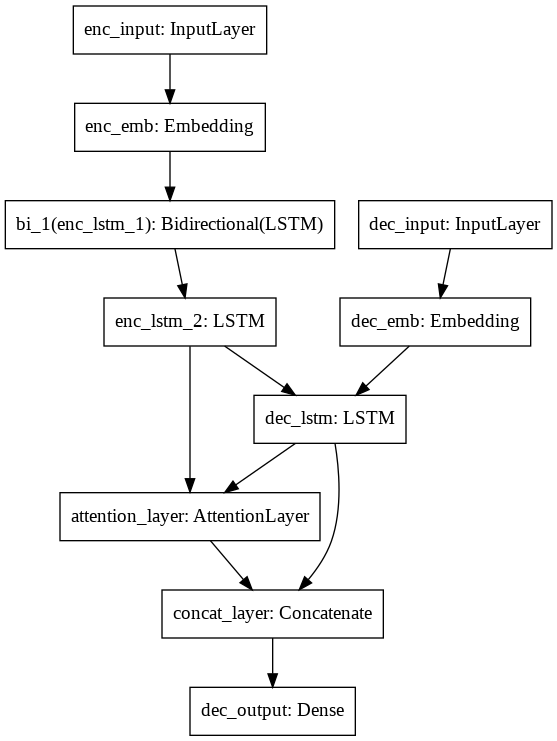

In [153]:
tf.keras.utils.plot_model(model)

## Train Model

### Build Target Set

In [0]:
y_train_post = y_train[:,:-1]

y_train_post_2 = y_train.reshape(y_train.shape[0], y_train.shape[1], -1)[:,1:]

y_val_post = y_val[:,:-1]

y_val_post_2 = y_val.reshape(y_val.shape[0], y_val.shape[1], -1)[:,1:]

### Establish Callbacks

In [155]:
# Early Stopping

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Checkpointing Model Weights

import os

checkpoint_path = 'checkpoints/cp-{epoch:03d}.ckpt'

checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                                                   save_weights_only=True, period=1)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

latest_checkpoint

'checkpoints/cp-005.ckpt'

### Train Model

In [157]:
batch_size = 256

epochs = 1

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.load_weights(latest_checkpoint)

history = model.fit([X_train, y_train_post], y_train_post_2,
                    validation_data=([X_val, y_val_post], y_val_post_2),
                    batch_size=batch_size, epochs=epochs, callbacks=[early_stop, checkpoint_cb])

163/163 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8852
Epoch 00001: saving model to checkpoints/cp-001.ckpt
163/163 [==============================] - 148s 906ms/step - loss: 0.4232 - accuracy: 0.8852 - val_loss: 0.4204 - val_accuracy: 0.8863


## Save Model and Tokenizers

### Model

In [0]:
# Model

drive_path = '/content/drive/'

file_path = 'My Drive/saved_enc_dec_tokenizer_rouge/'

name = 'enc_dec_master_same.h5'

model.save(drive_path + file_path + name)

# Tokenizer

import pickle

name = 'tok_enc_dec_master_same.pkl'

pickle.dump(x_tokenizer, open(drive_path + file_path + name, 'wb'))

# (Optional) Rouge Scores

name = 'rouge_score_master_same.pkl'

pickle.dump((rouge_score, rouge_adv_score), open(drive_path + file_path + name, 'wb'))

## Load Model and Tokenizers

### Model

In [0]:
drive_path = '/content/drive/'

file_path = 'My Drive/saved_keras_rnns/'

name = 'enc_dec_main.h5'

model = keras.models.load_model(drive_path + file_path + name, custom_objects={'AttentionLayer': AttentionLayer})

### Tokenizers

In [0]:
name = 'tok_enc_dec_main.pkl'

tokenizers_tuple = pickle.load(open(drive_path + file_path + name, 'rb'))

## Get Word Indices

In [0]:
reverse_source_word_index = x_tokenizer.index_word

reverse_target_word_index = x_tokenizer.index_word

target_word_index = x_tokenizer.word_index

## a) Model Inference and b) Decode Sequence

In [0]:
''' MODEL INFERENCE '''

# encoder inference
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(n_neurons,))
decoder_state_input_c = tf.keras.layers.Input(shape=(n_neurons,))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(max_len_text, n_neurons))

# Get the embeddings of the decoder sequence
dec_emb_2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_2, state_h2, state_c2 = decoder_lstm(dec_emb_2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs_2])
decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs_2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_4 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = tf.keras.Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                               [decoder_outputs_4] + [state_h2, state_c2])

''' DECODE SEQUENCE FUNC ET AL '''

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False

    decoded_sentence = ''

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':

            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word
        if (sampled_token == 'end') or (len(decoded_sentence.split()) >= (max_len_summary-1)):
                
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))

        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

''' SEQ2SUMMARY FUNC '''

def seq2summary(input_seq):

    new_string = ''

    for i in input_seq:

      if ((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):

        new_string = new_string + reverse_target_word_index[i] + ' '

    return new_string

''' SEQ2TEXT FUNC '''

def seq2text(input_seq):

    new_string = ''

    for i in input_seq:

      if i != 0:

        new_string = new_string + reverse_source_word_index[i] + ' '
        
    return new_string

## Tokenize Test Text

In [0]:
test_text = x_tokenizer.texts_to_sequences(test_df['Cleaned_text'])

test_text = pad_sequences(test_text, maxlen=max_len_text, padding='post')

test_sum = x_tokenizer.texts_to_sequences(test_df['Cleaned_summary'])

test_sum = pad_sequences(test_sum, maxlen=max_len_summary, padding='post')

## Show Predictions

In [161]:
predicted_summs = []

actual_summs = []

for i in range(len(test_text)):

  print('Review:', seq2text(test_text[i]))

  print('Original summary:', seq2summary(test_sum[i]))

  actual_summs.append(seq2summary(test_sum[i]))

  print('Predicted summary:', decode_sequence(test_text[i].reshape(1, max_len_text)))

  predicted_summs.append(decode_sequence(test_text[i].reshape(1, max_len_text)))

  print('\n')

Streaming output truncated to the last 5000 lines.
Original summary: denied loan modification 
Predicted summary:  auto loan


Review: xxxx sent written notice automated collection services inc via certified mail required cease desist contacting family members related matters unless united states mail phone records showing multiple calls xxxx letter debt collection abuse harassment believe automated collection services violating rights federal fair debt collection practices act 
Original summary: harassing calls 
Predicted summary:  harassing calls


Review: xxxx navient withdrew checking account without permission left month realize withdrawal made late evening xxxx friday navient longer open open weekends wait till monday morning call request returned account told earliest money could refunded days would mark urgent would mean would refunded xxxx xxxx still weeks away told navient took money put autopay completely false steady income would never put account autopay nothing autopay to

In [0]:
predicted_summs_2, actual_summs_2 = [], []

for pred, actual in list(zip(predicted_summs, actual_summs)):

  if actual != '':
    
    predicted_summs_2.append(pred)
    actual_summs_2.append(actual)

rouge = Rouge()

rouge_score = rouge.get_scores(predicted_summs_2, actual_summs_2, avg=True)

In [163]:
def rouge_adv_scorer(rouge_score):

  rouge_1 = rouge_score['rouge-1']['f']

  rouge_2 = rouge_score['rouge-2']['f']

  rouge_1_sq = rouge_1 ** 2

  output = np.cbrt((3 * rouge_1_sq * rouge_2) / (rouge_1 + rouge_1 + rouge_2))

  return output

rouge_adv_score = rouge_adv_scorer(rouge_score)

rouge_score, rouge_adv_score

({'rouge-1': {'f': 0.47536666401531863,
   'p': 0.4786666666666664,
   'r': 0.4758666666666664},
  'rouge-2': {'f': 0.43159999779775415, 'p': 0.4335, 'r': 0.43174999999999997},
  'rouge-l': {'f': 0.47313333068142976,
   'p': 0.47633333333333305,
   'r': 0.47344999999999976}},
 0.5959581800639988)

In [164]:
import pickle

drive_path = '/content/drive/'

file_path = 'My Drive/saved_enc_dec_tokenizer_rouge/'

name = 'rouge_score_master_same.pkl'

rouge_score_tuple = pickle.load(open(drive_path + file_path + name, 'rb'))

rouge_score_tuple

({'rouge-1': {'f': 0.4803166639928817,
   'p': 0.4836666666666665,
   'r': 0.4800666666666666},
  'rouge-2': {'f': 0.44013333109311525, 'p': 0.442, 'r': 0.43949999999999995},
  'rouge-l': {'f': 0.4796595211356368,
   'p': 0.48299999999999976,
   'r': 0.4793166666666666}},
 0.601356037048851)

## Score Custom Sentence

## Count Instances and Graph

In [0]:
summ_dict = {}

for item in predicted_summs:

  if item in summ_dict.keys():

    summ_dict[item] += 1
  
  else:

    summ_dict[item] = 1

In [166]:
summ_dict = sorted(summ_dict.items(), key=lambda x: x[1], reverse=True)

summ_dict

[(' harassing calls', 208),
 (' incorrect account information', 132),
 (' violation of fcra', 102),
 (' auto loan', 64),
 (' disputed account', 62),
 (' mortgage loan issue', 49),
 (' unauthorized charges', 46),
 (' property damage check', 39),
 (' poor customer service', 27),
 (' debt collection', 22),
 (' equifax hack', 21),
 (' fcra violation', 20),
 (' unauthorized credit report', 16),
 (' loan modification', 16),
 (' student loan issues', 15),
 (' denied loan modification', 15),
 (' unauthorized inquiry', 13),
 (' navient student loans', 11),
 (' restructure loan payments', 8),
 (' unauthorized interest rate', 7),
 (' inaccurate credit report', 7),
 (' unauthorized charge', 7),
 (' leasing application', 7),
 (' promotional terms', 6),
 (' horrible customer service', 6),
 (' not the best', 4),
 (' dented cans', 4),
 (' made in china', 4),
 (' denied loan', 4),
 (' unauthorized transactions', 4),
 (' incorrect name', 4),
 (' not as advertised', 3),
 (' not bad', 3),
 (' late payment

In [0]:
items = []

counts = []

for comb in summ_dict:

  item, count = comb[0], comb[1]

  items.append(item)

  counts.append(count)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


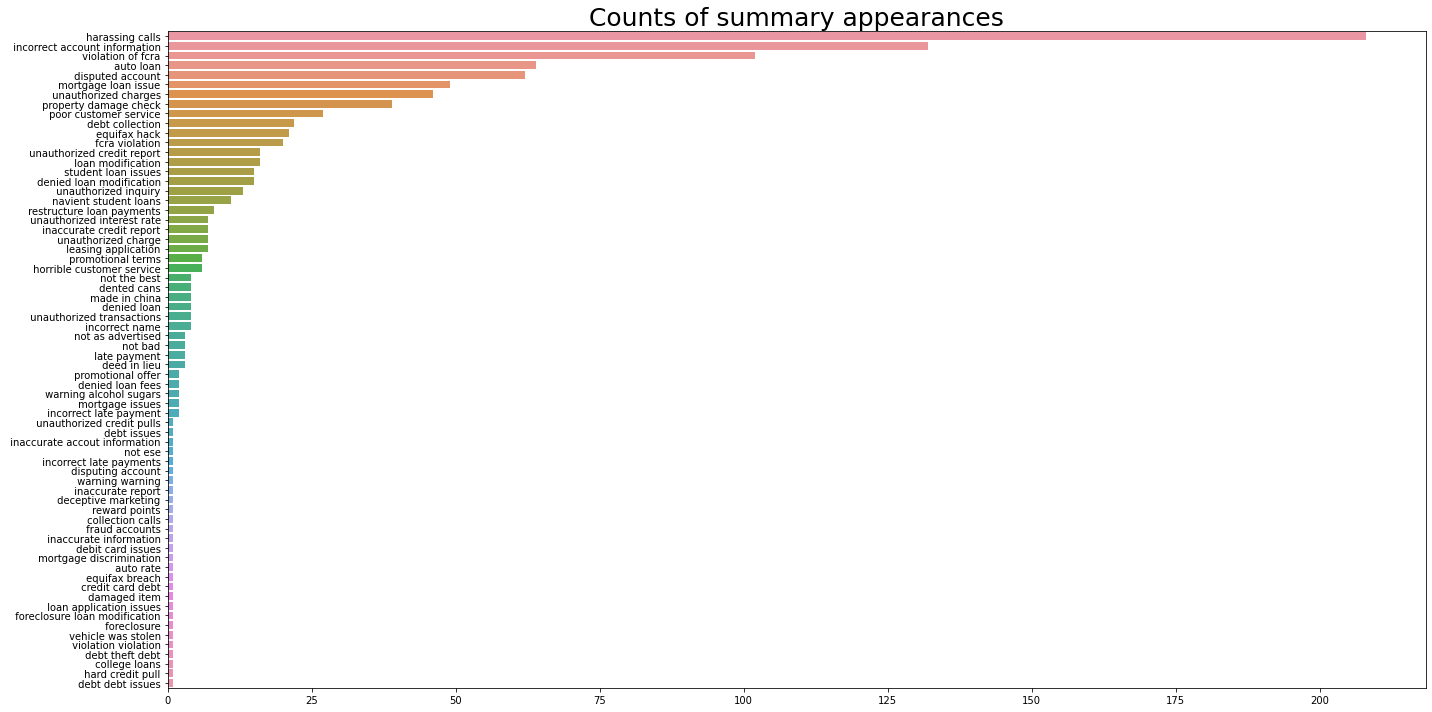

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(counts, items, orient='h', ax=ax)

ax.set_title('Counts of summary appearances', fontsize=25)

plt.tight_layout()

# (If Bootstrapping More Text-to-Summary) Load CFPB DataFrame

In [0]:
full_df = pd.read_csv('/content/drive/My Drive/Consumer_Complaints.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
proc_df = full_df.dropna(subset=['Consumer complaint narrative']).sample(5000, random_state=33)

## Process Entire CFPB DataFrame

In [0]:
clean = [re.sub('[^A-Za-z.,\s\']', '', str(text)) for text in proc_df['Consumer complaint narrative']]

split_word_nars = [nar.split() for nar in clean]

"""Contractions Import"""

import sys
sys.path.append('/content/drive/My Drive')
from english_contractions import replace_contraction

""" Stop Words Import """

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

""" Loops """

new_words = []

for nar in split_word_nars:

  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append('.')
    
    elif re.search('\w+[,]', word):
      
      splitted = word.split(',')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

      nar_words.append(',')
    
    elif re.match('[.]', word):
      
      placeholder = 1
    
    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)
  
  nar_words = [word for word in nar_words if not word in stops]

  new_words.append(' '.join(nar_words))

texts = new_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
proc_df['Cleaned_complaint'] = texts

proc_df = proc_df.reset_index(drop=True)

In [0]:
clean_text = x_tokenizer.texts_to_sequences(proc_df['Cleaned_complaint'])

clean_text = pad_sequences(clean_text, maxlen=max_len_text, padding='post')

In [0]:
predicted_summaries = []

import time

start = time.time()

for j, i in enumerate(range(len(proc_df))):

  if j % 50 == 0:

    print(j)
    print(time.time() - start)

  predicted_summaries.append(decode_sequence(clean_text[i].reshape(1, max_len_text)))

0
0.00033402442932128906
50
7.348793029785156
100
14.337061166763306
150
21.192152738571167
200
27.988800525665283
250
34.73090410232544
300
41.61622166633606
350
48.446823596954346
400
55.30856132507324
450
62.77237319946289
500
69.54851627349854
550
76.5398268699646
600
83.29291844367981
650
90.17930603027344
700
97.03169345855713
750
103.83302044868469
800
111.43368768692017
850
118.2259521484375
900
125.11571478843689
950
131.85437178611755
1000
138.3972475528717
1050
145.2599241733551
1100
151.9377670288086
1150
159.38377499580383
1200
166.52034950256348
1250
173.24480748176575
1300
179.9546194076538
1350
186.75111150741577
1400
193.48574113845825
1450
200.27273774147034
1500
207.69274234771729
1550
214.5420663356781
1600
221.2660849094391
1650
227.9238247871399
1700
234.8046407699585
1750
241.54408311843872
1800
248.34515762329102
1850
255.6342809200287
1900
262.4505639076233
1950
269.37571930885315
2000
276.1781761646271
2050
282.88718485832214
2100
289.94119334220886
2150
296.9

In [0]:
cleaned_text = []

for i in range(len(predicted_summaries)):

  text = seq2text(clean_text[i])
  
  cleaned_text.append(text)

In [0]:
bootstrap_df = pd.DataFrame({'Text': cleaned_text[:len(predicted_summaries)], 'Summary': predicted_summaries})

In [0]:
import pickle

path = '/content/drive/My Drive/'

tmp_df = pickle.load(open(path + 'bootstrap_cfpb_df_main', 'rb'))

b_df = tmp_df.append(bootstrap_df)

pickle.dump(b_df, open('/content/drive/My Drive/bootstrap_cfpb_df_main', 'wb'))

# Potentially Deprecated

In [0]:
clean_df = bootstrap_df[['Text', 'Summary']]

target_texts = []

for target_text in clean_df['Summary']:

  target_text = '_START_ ' + str(target_text) + ' _END_'

  target_texts.append(target_text)

clean_df['Summary'] = target_texts

In [0]:
max_len_text = 200

max_len_summary = 5

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(bootstrap_df['Text'], bootstrap_df['Summary'], test_size=0.2, random_state=0, shuffle=True)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = tf.keras.preprocessing.text.Tokenizer()

x_tokenizer.fit_on_texts(list(X_train))

# convert text sequences into integer sequences
X_train = x_tokenizer.texts_to_sequences(X_train)
X_val = x_tokenizer.texts_to_sequences(X_val)

# padding zero up to maximum length
X_train = pad_sequences(X_train, maxlen=max_len_text, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

x_voc_size

11160

In [0]:
y_tokenizer = tf.keras.preprocessing.text.Tokenizer()

y_tokenizer.fit_on_texts(list(y_train))

# convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train)
y_val = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

y_voc_size

165

In [0]:
import tensorflow_addons as tfa

n_neurons = 512

embedding_dims = 512

dropout_rate, recurrent_dropout_rate = 0.5, 0

dec_rec_dropout_rate = 0 # recurrent dropout rate for decoder lstm

# Encoder 
encoder_inputs = tf.keras.layers.Input(shape=[max_len_text,],
                                       name='enc_input')
enc_emb_layer = tf.keras.layers.Embedding(x_voc_size, embedding_dims, trainable=True,
                                          name='enc_emb')
enc_emb = enc_emb_layer(encoder_inputs)

# LSTM 1 
encoder_lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                                                    dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
                                                                    name='enc_lstm_1'),
                                                                    name='bi_1')
encoder_output_1, state_h1, _, state_c1, _ = encoder_lstm_1(enc_emb)

# LSTM 2
encoder_lstm_3 = tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                      dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
                                      name='enc_lstm_2')
encoder_outputs, state_h, state_c = encoder_lstm_3(encoder_output_1)

# Set up the decoder
decoder_inputs = tf.keras.layers.Input(shape=[None,],
                                       name='dec_input')
dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, embedding_dims, trainable=True,
                                          name='dec_emb')
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = tf.keras.layers.LSTM(n_neurons, return_sequences=True, return_state=True,
                                    dropout=dropout_rate, recurrent_dropout=dec_rec_dropout_rate,
                                    name='dec_lstm')
decoder_output_1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_output_1])
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_output_1, attn_out])

# Dense output
decoder_dense = tf.keras.layers.Dense(y_voc_size, activation='softmax',
                                      name='dec_output')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, 200, 512)     5713920     enc_input[0][0]                  
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
bi_1 (Bidirectional)            [(None, 200, 1024),  4198400     enc_emb[0][0]                    
___________________________________________________________________________________________

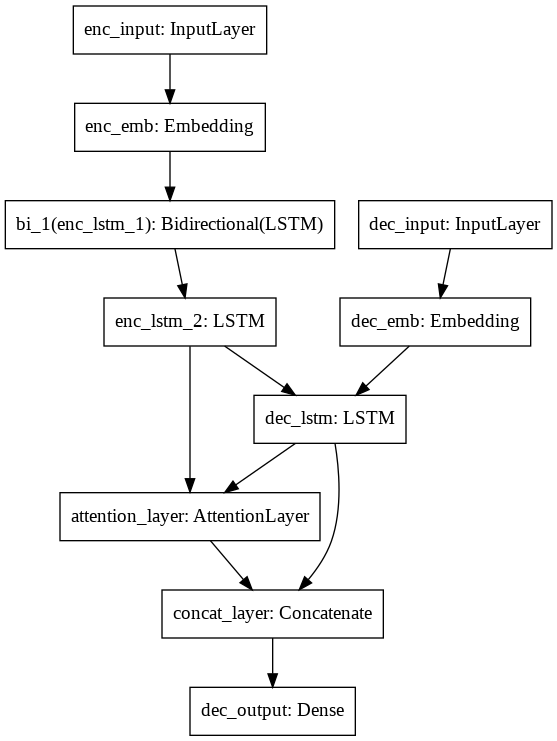

In [0]:
tf.keras.utils.plot_model(model)

In [0]:
y_train_post = y_train[:,:-1]

y_train_post_2 = y_train.reshape(y_train.shape[0], y_train.shape[1], -1)[:,1:]

y_val_post = y_val[:,:-1]

y_val_post_2 = y_val.reshape(y_val.shape[0], y_val.shape[1], -1)[:,1:]

In [0]:
# Early Stopping

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Checkpointing Model Weights

import os

checkpoint_path = 'checkpoints/cp-{epoch:03d}.ckpt'

checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                                                   save_weights_only=True, period=3)

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

latest_checkpoint

'checkpoints/cp-006.ckpt'

In [0]:
batch_size = 256

epochs = 6

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.load_weights(latest_checkpoint)

history = model.fit([X_train, y_train_post], y_train_post_2,
                    validation_data=([X_val, y_val_post], y_val_post_2),
                    batch_size=batch_size, epochs=epochs, callbacks=[early_stop, checkpoint_cb])

Epoch 1/6
74/74 [==============================] - 46s 616ms/step - loss: 0.8627 - accuracy: 0.8273 - val_loss: 0.2375 - val_accuracy: 0.9518
Epoch 2/6
74/74 [==============================] - 43s 581ms/step - loss: 0.1616 - accuracy: 0.9603 - val_loss: 0.1187 - val_accuracy: 0.9655
Epoch 3/6
74/74 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9675
Epoch 00003: saving model to checkpoints/cp-003.ckpt
74/74 [==============================] - 43s 588ms/step - loss: 0.1072 - accuracy: 0.9675 - val_loss: 0.0969 - val_accuracy: 0.9695
Epoch 4/6
74/74 [==============================] - 43s 581ms/step - loss: 0.0908 - accuracy: 0.9710 - val_loss: 0.0985 - val_accuracy: 0.9693
Epoch 5/6
74/74 [==============================] - 43s 583ms/step - loss: 0.0821 - accuracy: 0.9733 - val_loss: 0.0896 - val_accuracy: 0.9697
Epoch 6/6
74/74 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9719
Epoch 00006: saving model to checkpoints/cp-006.ckpt
74/74 [=

In [0]:
# encoder inference
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(n_neurons,))
decoder_state_input_c = tf.keras.layers.Input(shape=(n_neurons,))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(max_len_text, n_neurons))

# Get the embeddings of the decoder sequence
dec_emb_2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_2, state_h2, state_c2 = decoder_lstm(dec_emb_2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs_2])
decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs_2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_4 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = tf.keras.Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                               [decoder_outputs_4] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False

    decoded_sentence = ''

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':

            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word
        if (sampled_token == 'end') or (len(decoded_sentence.split()) >= (max_len_summary-1)):
                
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))

        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):

    new_string = ''

    for i in input_seq:

      if ((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):

        new_string = new_string + reverse_target_word_index[i] + ' '

    return new_string

def seq2text(input_seq):

    new_string = ''

    for i in input_seq:

      if i != 0:

        new_string = new_string + reverse_source_word_index[i] + ' '
        
    return new_string

In [0]:
test_df = bootstrap_df.sample(10, random_state=42)

In [0]:
test_text = x_tokenizer.texts_to_sequences(test_df['Text'])

test_text = pad_sequences(test_text, maxlen=max_len_text, padding='post')

test_sum = y_tokenizer.texts_to_sequences(test_df['Summary'])

test_sum = pad_sequences(test_sum, maxlen=max_len_summary, padding='post')